Library


In [75]:
import pickle
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import skfuzzy as fuzz
from skfuzzy import control as ctrl
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Path


In [76]:
PATH_MAIN = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# PATH_MAIN = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

PATH_DATASET = f"{PATH_MAIN}/Dataset"

Konstanta


In [77]:
SAMPLE_RATE = 48000
BATCH_SIZE = 32
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)
RANDOM_STATE = 21
BUFFER_SIZE = 1000

Random Seed


In [78]:
RANDOM_SEED = 21

try:
    from sklearn.utils import check_random_state
    random_state = check_random_state(RANDOM_SEED)
except ImportError:
    pass

# Dataset


Load Dataset Raw


In [79]:
with open(f"{PATH_DATASET}/dataset_fe.pkl", "rb") as f:
    dataset = pickle.load(f)

Checking


In [80]:
len(dataset)

1894

In [81]:
dataset[0]

{'path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
 'name': '19655.mp3',
 'timestamp': [0.0, 1.0],
 'label': 2,
 'raw': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
         1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32),
 'rms': 0.011059444,
 'spectral_flatness': 0.011423797,
 'mfcc': array([[-9.2709552e+02, -9.2709552e+02, -8.6692578e+02, ...,
         -4.9831238e+02, -4.7504291e+02, -3.9764847e+02],
        [ 0.0000000e+00,  0.0000000e+00, -1.4798780e+01, ...,
         -8.1901199e+01, -5.0254303e+01,  2.3999417e+00],
        [ 0.0000000e+00,  0.0000000e+00, -5.1890976e+01, ...,
         -2.6562943e+02, -2.3930214e+02, -1.4375620e+02],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  8.7950077e+00, ...,
          7.3784947e-01,  1.3385715e+00,  2.1685948e+00],
        [ 0.0000000e+00,  0.0000000e+00, -1.2696293e+01, ...,
          5.2022276e+00,  3.3751645e+00, -6.7336679e+00],


`Label 1 untuk suara non-burung dan 0 untuk suara burung`


Assign variabel X dan y


In [82]:
feature = ["rms", "spectral_flatness"]

X = [[data[f] for f in feature] for data in dataset]
original_labels = [int(data["label"]) for data in dataset]
y = [1 if label == 0 or label == 1 else 2 for label in original_labels]

Check


In [83]:
pd.Series(y).value_counts()

1    1337
2     557
Name: count, dtype: int64

In [84]:
print("Data:\n", X[0])
print("Label: ", y[0])

Data:
 [0.011059444, 0.011423797]
Label:  2


Split


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE, stratify=y_test)

Normalisasi


In [86]:
scl = StandardScaler()
X_train_scaled = scl.fit_transform(X_train)
X_test_scaled = scl.transform(X_test)
X_val_scaled = scl.transform(X_val)

Save scaler


In [87]:
joblib.dump(scl, f'{PATH_MAIN}/model/p_scaler.pkl')

['C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar/model/p_scaler.pkl']

Check


In [88]:
display(
    X_train_scaled.shape,
    X_test_scaled.shape,
    X_val_scaled.shape
)

(1515, 2)

(189, 2)

(190, 2)

# Train


Model yang akan digunakan untuk klasifikasi suara burung:

1. Fuzzy Mamdani
2. Fuzzy Sugeno
3. Logistic Regression
4. Descision Tree
5. LGBM Classifier


## Fuzzy Mamdani


In [89]:
rms = ctrl.Antecedent(np.linspace(-1, 8, 100), 'rms')
flatness = ctrl.Antecedent(np.linspace(-1, 4, 100), 'flatness')
label = ctrl.Consequent(np.linspace(1, 2, 100), 'label')

rms['low'] = fuzz.trapmf(rms.universe, [-1, -1, -0.67, -0.565])
rms['medium'] = fuzz.trimf(rms.universe, [-0.67, -0.565, -0.46])
rms['high'] = fuzz.trapmf(rms.universe, [-0.565, -0.46, 8, 8])

flatness['rigid'] = fuzz.trapmf(flatness.universe, [-1, -1, -0.45, -0.35])
flatness['smooth'] = fuzz.trapmf(flatness.universe, [-0.45, -0.35, 4, 4])

label['event'] = fuzz.trimf(label.universe, [1, 1, 1])
label['nonevent'] = fuzz.trimf(label.universe, [2, 2, 2])

rule1 = ctrl.Rule(flatness['smooth'] & rms['low'], label['nonevent'])
rule2 = ctrl.Rule(flatness['smooth'] & rms['medium'], label['nonevent'])
rule3 = ctrl.Rule(flatness['smooth'] & rms['high'], label['event'])
rule4 = ctrl.Rule(flatness['rigid'] & rms['low'], label['nonevent'])
rule5 = ctrl.Rule(flatness['rigid'] & rms['medium'], label['nonevent'])
rule6 = ctrl.Rule(flatness['rigid'] & rms['high'], label['event'])

mamdani_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

def fuzzy_inference(rms_value, flatness_value):
    system = ctrl.ControlSystemSimulation(mamdani_ctrl)
    try:
        system.input['rms'] = np.clip(rms_value, -1, 1)
        system.input['flatness'] = np.clip(flatness_value, -1, 1)
        system.compute()
        return system.output['label']
    except KeyError:
        return 1.5

def inferensi_mamdani(X):
    y_pred = []
    for data in X:
        output = fuzzy_inference(data[0], data[1])
        predicted_class = int(round(output))
        y_pred.append(predicted_class)
    return np.array(y_pred)

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


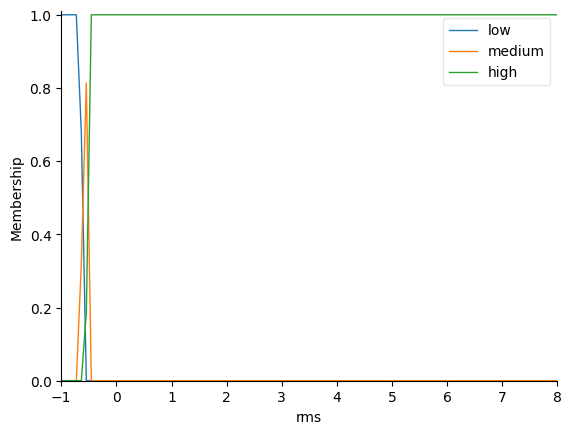

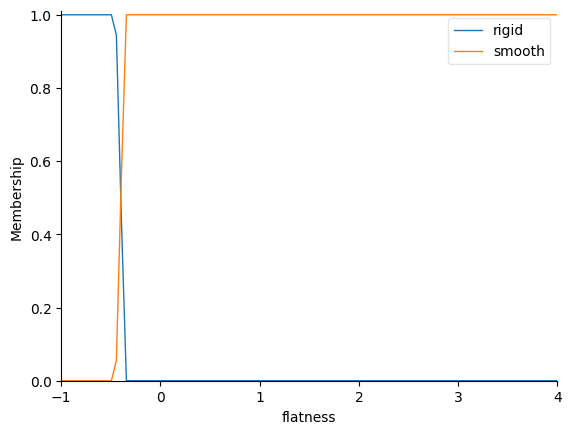

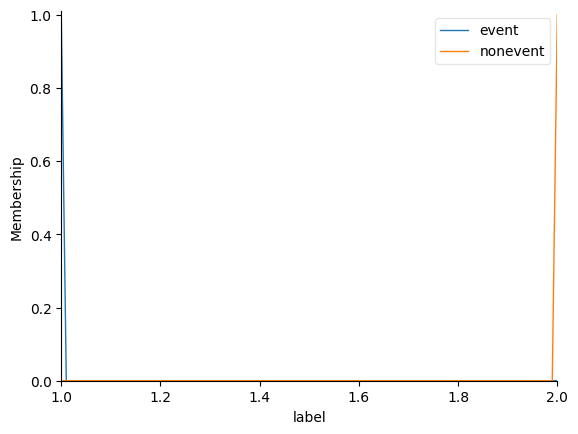

In [90]:
rms.view()
flatness.view()
label.view()


evaluasi


In [91]:
y_pred = inferensi_mamdani(X_val_scaled)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_val, y_pred)}")

Validasi
Accuracy: 0.9157894736842105
Precision: 0.9682539682539683
Recall: 0.9104477611940298
F1 Score: 0.9384615384615385
Confusion Matrix:
 [[122  12]
 [  4  52]]


In [92]:
y_pred = inferensi_mamdani(X_test_scaled)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Validasi
Accuracy: 0.9417989417989417
Precision: 0.9624060150375939
Recall: 0.9552238805970149
F1 Score: 0.9588014981273408
Confusion Matrix:
 [[128   6]
 [  5  50]]


## Fuzzy Sugeno


## Logistic Regression


Inisialisasi


In [93]:
lr_model = LogisticRegression(random_state=RANDOM_STATE)

training


In [94]:
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=21)

evaluasi


In [95]:
y_pred = lr_model.predict(X_val_scaled)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_val, y_pred)}")

Validasi
Accuracy: 0.9210526315789473
Precision: 0.9612403100775194
Recall: 0.9253731343283582
F1 Score: 0.9429657794676806
Confusion Matrix:
 [[124  10]
 [  5  51]]


In [96]:
y_pred = lr_model.predict(X_test_scaled)

print("Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Test
Accuracy: 0.9206349206349206
Precision: 0.9280575539568345
Recall: 0.9626865671641791
F1 Score: 0.945054945054945
Confusion Matrix:
 [[129   5]
 [ 10  45]]


Save


In [97]:
joblib.dump(lr_model, f'{PATH_MAIN}/model/p_lr.pkl')

['C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar/model/p_lr.pkl']

## Descision Tree


Inisialisasi


In [98]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5)

training


In [99]:
dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=5, random_state=21)

evaluasi


In [100]:
y_pred = dt_model.predict(X_val_scaled)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_val, y_pred)}")

Validasi
Accuracy: 0.9052631578947369
Precision: 0.9754098360655737
Recall: 0.8880597014925373
F1 Score: 0.9296875
Confusion Matrix:
 [[119  15]
 [  3  53]]


In [101]:
y_pred = dt_model.predict(X_test_scaled)

print("Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Test
Accuracy: 0.9576719576719577
Precision: 1.0
Recall: 0.9402985074626866
F1 Score: 0.9692307692307692
Confusion Matrix:
 [[126   8]
 [  0  55]]


Save


In [102]:
joblib.dump(dt_model, f'{PATH_MAIN}/model/p_dt.pkl')

['C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar/model/p_dt.pkl']

## LGBM


Inisialisasi


In [103]:
lgbm_model = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)

training


In [104]:
lgbm_model.fit(X_train_scaled, y_train)

LGBMClassifier(random_state=21, verbose=-1)

evaluasi


In [105]:
y_pred = lgbm_model.predict(X_val_scaled)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_val, y_pred)}")

Validasi
Accuracy: 0.9315789473684211
Precision: 0.9763779527559056
Recall: 0.9253731343283582
F1 Score: 0.9501915708812261
Confusion Matrix:
 [[124  10]
 [  3  53]]


In [106]:
y_pred = lgbm_model.predict(X_test_scaled)

print("Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Test
Accuracy: 0.9417989417989417
Precision: 0.9624060150375939
Recall: 0.9552238805970149
F1 Score: 0.9588014981273408
Confusion Matrix:
 [[128   6]
 [  5  50]]


Save


In [107]:
joblib.dump(lgbm_model, f'{PATH_MAIN}/model/p_lgbm.pkl')

['C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar/model/p_lgbm.pkl']